In [1]:
import numpy as np
import matplotlib.pyplot as plt
from smoothness import periodic
from stencils.teno5dv import TENO5DUCROS_D, TENO5DUCROS_V
from stencils.teno8 import TENO8
from stencils.weno9 import WENO9
from stencils.teno5 import TENO5
figsize = (5, 4)
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["mathtext.fontset"] = "stix"
label_fontsize=10
ticks_fontsize=8
title_fontsize=12
linewidth=1

In [2]:
N = 331
h = 1 / N
n = np.arange(0, int(N / 2) + 1)
t = 0.00001
phi_n = 2 * np.pi * n / N
lambda_ = 1 / n
xs = np.arange(0, 1, h) + h / 2
delta = 1 * t / h


def cal_spectral(stencil, size, index):
    r"""
    refer to "On the spectral properties of shock-capturing schemes", Pirozzoli, 2006
    :param stencil: reconstruction stencil
    :param size: boundary width
    :param index: index of the shift cells
    :return: real part (dispersion) and imaginary part (dissipation)
    """
    v_hat = []
    for i, phi in enumerate(phi_n):
        y_ori = np.sin(2 * np.pi * xs / lambda_[i])
        y_bound = periodic(y_ori, halo_size=size)
        temp1, temp2 = 0, 0
        for j in range(size, N + size):
            pos_array = [y_bound[j + k] for k in index]
            neg_array = [y_bound[j + k - 1] for k in index]
            pos = stencil.apply(pos_array)
            neg = stencil.apply(neg_array)
            temp1 += (y_bound[j] - 1 * t / h * (pos - neg)) * np.exp(complex(0, -(j - size) * phi))
            temp2 += y_bound[j] * np.exp(complex(0, -(j - size) * phi))
        v_hat.append(temp1 / temp2)
    v_hat = np.array(v_hat)
    out = -1 / complex(0, delta) * np.log(v_hat)
    return out.real, out.imag

/var/folders/j4/d02ryb6s40n8_rvqwthnxshw0000gn/T/ipykernel_76878/1123884373.py:6: RuntimeWarning: divide by zero encountered in divide
  lambda_ = 1 / n


In [3]:
results = []
qs = np.arange(1, 11, 2)
cqs = np.arange(0, 25, 5)
cqs[0] = 1
etas = np.arange(0.1, 0.91, 0.1).round(2)
real_linear, imag_linear = cal_spectral(TENO5(d0=0.6, d1=0.3, d2=0.1, nonlinear=False), 3, [-2, -1, 0, 1, 2])
results.append([real_linear, imag_linear])
real_weno9, imag_weno9 = cal_spectral(WENO9(), 5, [-4, -3, -2, -1, 0, 1, 2, 3, 4])
results.append([real_weno9, imag_weno9])

# real_weno5, imag_weno5 = cal_spectral(TENO5(d0=0.5, d1=0.5, d2=0.0, nonlinear=False), 3, [-2, -1, 0, 1, 2])
# results.append([real_weno5, imag_weno5])
real_teno5, imag_teno5 = cal_spectral(TENO5(d0=0.6, d1=0.3, d2=0.1), 3, [-2, -1, 0, 1, 2])
results.append([real_teno5, imag_teno5])
# real_teno8a, imag_teno8a = cal_spectral(TENO8A(), 4, [-3, -2, -1, 0, 1, 2, 3, 4])
# results.append([real_teno8a, imag_teno8a])
# real_teno5lin, imag_teno5lin = cal_spectral(TENO5(d0=0.55, d1=0.4, d2=0.05), 3, [-2, -1, 0, 1, 2])
# results.append([real_teno5lin, imag_teno5lin])
real_teno8, imag_teno8 = cal_spectral(TENO8(), 4, [-3, -2, -1, 0, 1, 2, 3, 4])
results.append([real_teno8, imag_teno8])
coefs2 = [
    [ 0.4558, 0.4246, 0.0539]
]
for coef in coefs2:
    real, imag = cal_spectral(TENO5DUCROS_D(coef), 3, [-2, -1, 0, 1, 2])
    results.append([real, imag])
    # real, imag = cal_spectral(TENO5DUCROS_V(coef), 3, [-2, -1, 0, 1, 2])
    # results.append([real, imag])
    real, imag = cal_spectral(TENO5DUCROS_V(coef), 3, [-2, -1, 0, 1, 2])
    results.append([real, imag])



/var/folders/j4/d02ryb6s40n8_rvqwthnxshw0000gn/T/ipykernel_76878/1123884373.py:31: RuntimeWarning: invalid value encountered in cdouble_scalars
  v_hat.append(temp1 / temp2)


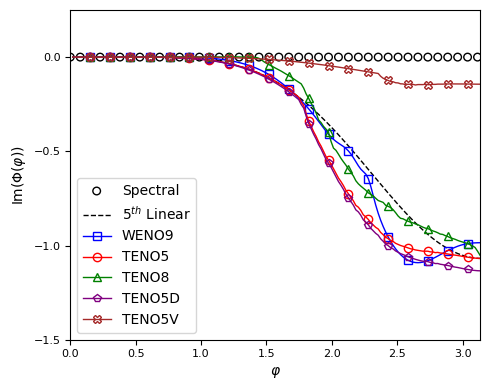

In [4]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(phi_n[::4], np.zeros(int(N / 2) + 1)[::4], marker="o", facecolor="none", edgecolor="black", label="Spectral", alpha=1, s=30, linewidth=linewidth)
imag = results[0][1]
plt.plot(phi_n, imag, linewidth=1, c="black", linestyle="--", label=r"$5^{th}$ Linear")
# imag = results[1][1]
# plt.plot(phi_n, imag, linewidth=1.2, c="brown", linestyle="-.", label=r"$4^{th}$ Central")
# imag = results[2][1]
# plt.plot(phi_n, imag, linewidth=linewidth, c="green", linestyle="-", label=r"TENO5LIN")
colors = ["blue", "red", "green", "purple", "brown", "orange"]
labels = ["WENO9", "TENO5", "TENO8", "TENO5D", "TENO5V", ]
shapes = ["s", "o", "^", "p", "X", "P"]
for i, (_, imag) in enumerate(results[1:]):
    plt.plot(phi_n, imag, linewidth=linewidth, c=colors[i], label=labels[i], marker=shapes[i], markerfacecolor="none", markeredgecolor=colors[i], markersize=6, markeredgewidth=linewidth, markevery=8)
# plt.grid(alpha=0.25)
plt.ylim(-1.5, 0.25)
plt.xlim(phi_n[0], phi_n[-1])
# plt.title("Approximate Dissipation")
plt.xlabel(r"$\varphi$", fontsize=label_fontsize)
plt.ylabel(r"$\mathrm{Im}(\Phi(\varphi))$", fontsize=label_fontsize)
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(np.arange(-1.5, 0.25001, 0.5), fontsize=ticks_fontsize)
plt.legend(fontsize=label_fontsize, ncol=1)
plt.tight_layout()
plt.savefig("./dissipation.pdf", dpi=400)

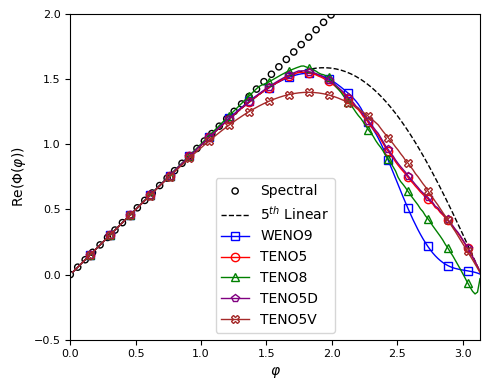

In [5]:
plt.figure(figsize=figsize, dpi=100)
plt.scatter(phi_n[::3], phi_n[::3], marker="o", facecolor="none", edgecolor="black", label="Spectral", alpha=1, s=20, linewidth=linewidth)
real = results[0][0]
plt.plot(phi_n, real, linewidth=1, c="black", linestyle="--", label=r"$5^{th}$ Linear")
# real = results[1][0]
# plt.plot(phi_n, real, linewidth=1.2, c="brown", linestyle="-.", label=r"$4^{th}$ Central")
# real = results[2][0]
# plt.plot(phi_n, real, linewidth=linewidth, linestyle="-", c="blue", label=r"TENO5", marker="s", markerfacecolor="none", markeredgecolor="blue", markevery=5)
# real = results[2][0]
# plt.plot(phi_n, real, linewidth=linewidth, linestyle="-", c="green", label=r"TENO5LIN")
for i, (real, _) in enumerate(results[1:]):
    plt.plot(phi_n, real, linewidth=linewidth, c=colors[i], label=labels[i], marker=shapes[i], markerfacecolor="none", markeredgecolor=colors[i], markersize=6, markeredgewidth=linewidth, markevery=8)
plt.ylim(-0.5, 2)
plt.xlim(phi_n[0], phi_n[-1])
# plt.title("Approximate Dispersion")
plt.xlabel(r"$\varphi$", fontsize=label_fontsize)
plt.ylabel(r"$\mathrm{Re}(\Phi(\varphi))$", fontsize=label_fontsize)
plt.xticks(fontsize=ticks_fontsize)
plt.yticks(fontsize=ticks_fontsize)
plt.tight_layout()
plt.legend(fontsize=label_fontsize, ncol=1)
# plt.grid(alpha=0.25)
plt.savefig("./dispersion.pdf", dpi=400)